# Data analysis of MNX dataset

To understand more about the reaction contained.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [2]:
reac = pd.read_csv('mnx_reac_bioreachable.csv')
for col in ['substrates_SMILES', 'products_SMILES']:
    reac[col] = reac[col].apply(eval) # convert list in strings into python list objects
reac

,#ID,equation,substrates_SMILES,products_SMILES
0,MNXR100011,1 MNXM1108175 + 1 MNXM1 + 2 MNXM27 + 1 MNXM403...,"[[H+], OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]...","[OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1O, [N..."
1,MNXR100018,1 MNXM1233 + 1 MNXM73 = 1 MNXM23 + 1 MNXM731248,"[OC[C@H](O)[C@@H](O)[C@@H](O)[C@H](O)CO, C=C(O...","[CC(=O)C(=O)[O-], O=P([O-])([O-])OC[C@H](O)[C@..."
2,MNXR100024,1 MNXM1 + 1 MNXM37 + 1 MNXM40333 + 1 MNXM9 = 1...,"[[H+], NC(=O)CC[C@H]([NH3+])C(=O)[O-], Nc1ncnc...",[Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=...
3,MNXR100030,1 MNXM37 + 1 WATER = 1 MNXM729302 + 1 MNXM741173,[NC(=O)CC[C@H]([NH3+])C(=O)[O-]],"[[NH4+], [NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]]"
4,MNXR100036,1 MNXM1104266 + 1 MNXM6274 = 1 MNXM6987 + 1 MN...,[CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)...,[CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C...
...,...,...,...,...
46305,MNXR99957,1 MNXM1627 + 1 WATER = 1 MNXM1734,[O=C([O-])C(=O)C[C@@H](O)[C@H](O)CO],[O=C([O-])[C@H](O)[C@@H](O)[C@@H](O)[C@H](O)CO]
46306,MNXR99976,1 MNXM1100890 + 1 MNXM1105733 = 1 MNXM1102128 ...,[CC(=O)N[C@H]1[C@@H](OP(=O)([O-])OP(=O)([O-])O...,[O=c1ccn([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-...
46307,MNXR99978,1 MNXM1100890 + 1 MNXM8636 = 1 MNXM1102128 + 1...,[CC(=O)N[C@H]1[C@@H](OP(=O)([O-])OP(=O)([O-])O...,[O=c1ccn([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-...
46308,MNXR99980,1 MNXM1100890 + 1 MNXM6274 = 1 MNXM1102128 + 1...,[CC(=O)N[C@H]1[C@@H](OP(=O)([O-])OP(=O)([O-])O...,[O=c1ccn([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-...


## Measure the difference between substrates and products

### Two strategies

1. Compare the number of atoms between biggest molecule in subtrates and products
    - Take the largest molecule from both substrates and products
    - Compute the difference in number of molecules between biggest substrates and biggest products

2. Compare the number of atoms between biggest molecule in substrates and products with the maximum common substructure (MCS)
    - Take the largest molecule from both substrates and products
    - Compute the MCS between those two molecules
    - Compute the max of difference in number of molecules between biggest molecules in either substrates or products and the MCS

In [3]:
from rdkit.Chem import MolFromSmiles, MolToSmiles, rdFMCS

def numAtoms(mol):
    return len(list(mol.GetAtoms()))

### First strategy - difference in number of atoms

In [4]:
diff_list = []
for i in trange(len(reac)):

    substrates_mol = [MolFromSmiles(smi) for smi in reac.loc[i, 'substrates_SMILES']]
    products_mol = [MolFromSmiles(smi) for smi in reac.loc[i, 'products_SMILES']]
    
    substrate_max = max(substrates_mol, key=numAtoms)
    product_max = max(products_mol, key=numAtoms)
    # print(MolToSmiles(substrate_max), MolToSmiles(product_max))

    diff = abs(numAtoms(substrate_max) - numAtoms(product_max))
    # print(diff)

    diff_list.append(diff)

100%|██████████| 46310/46310 [01:15<00:00, 616.97it/s]


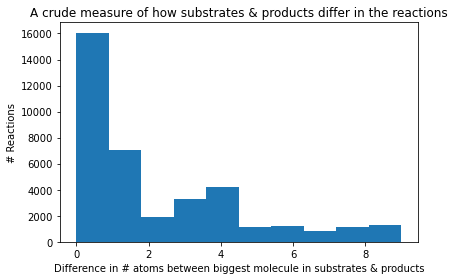

In [5]:
plt.hist([diff for diff in diff_list if diff < 10])
plt.ylabel('# Reactions')
plt.xlabel('Difference in # atoms between biggest molecule in substrates & products')
plt.title('A crude measure of how substrates & products differ in the reactions')

plt.tight_layout()
plt.show()

### Second strategy - maximum common substructure

In [6]:
diff_list = []
for i in trange(len(reac)):

    substrates_mol = [MolFromSmiles(smi) for smi in reac.loc[i, 'substrates_SMILES']]
    products_mol = [MolFromSmiles(smi) for smi in reac.loc[i, 'products_SMILES']]
    
    substrate_max = max(substrates_mol, key=numAtoms)
    product_max = max(products_mol, key=numAtoms)
    # print(MolToSmiles(substrate_max), MolToSmiles(product_max))

    mcs = rdFMCS.FindMCS([substrate_max, product_max], timeout=1)
    diff = max(abs(numAtoms(substrate_max) - mcs.numAtoms), abs(numAtoms(product_max) - mcs.numAtoms))
    # print(diff)

    diff_list.append(diff)

100%|██████████| 46310/46310 [1:19:31<00:00,  9.71it/s]  


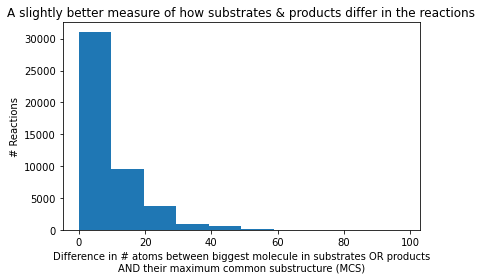

In [10]:
plt.hist([diff for diff in diff_list if diff < 100])
plt.ylabel('# Reactions')
plt.xlabel('Difference in # atoms between biggest molecule in substrates OR products\nAND their maximum common substructure (MCS)')
plt.title('A slightly better measure of how substrates & products differ in the reactions')

plt.tight_layout()
plt.show()

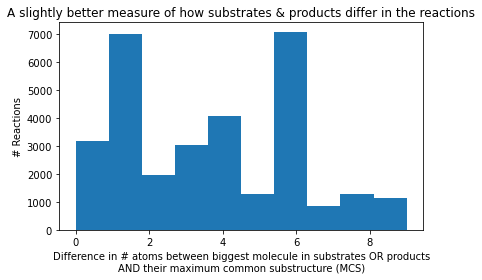

In [8]:
plt.hist([diff for diff in diff_list if diff < 10])
plt.ylabel('# Reactions')
plt.xlabel('Difference in # atoms between biggest molecule in substrates OR products\nAND their maximum common substructure (MCS)')
plt.title('A slightly better measure of how substrates & products differ in the reactions')

plt.tight_layout()
plt.show()